# Project work: A mini segmentation challenge

Imaging for the Life Sciences  
MSLS / CO4: Project work

**Student**: $\Rightarrow$ Mirco Blaser

**University**: $\Rightarrow$ ZHAW

**Semester**: $\Rightarrow$ 4th Semester

**Date**: $\Rightarrow$ June 3rd 2024


<br><br><br>
## Table of contents
<!-- Unfortunately, the following does not always work correctly -->
* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  
* [*. Hints](#sec_hints)  


---

## Prerequisites / Setup

$\Rightarrow$  Special setup instructions, imports and configurations go here.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import nibabel as nib
import pydicom
import PIL
from PIL import Image
import os

# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

import sys
sys.path.insert(0, "../")
import tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---

<a id='sec_dataset'></a>

## Dataset

Title: Satellite Images of Water Bodies

Source: [Kaggle](https://www.kaggle.com/datasets/franciscoescobar/satellite-images-of-water-bodies)

Description: A collection of water bodies images captured by the Sentinel-2 Satellite. Each image comes with a black and white mask where white represents water and black represents something else but water. The masks were generated by calculating the NWDI (Normalized Water Difference Index) which is frequently used to detect and measure vegetation in satellite images, but a greater threshold was used to detect water bodies.

- **Images**: These are the raw satellite images.
- **Masks**: These are the binary masks where water bodies are labeled.

Below are examples of the images and their corresponding masks:

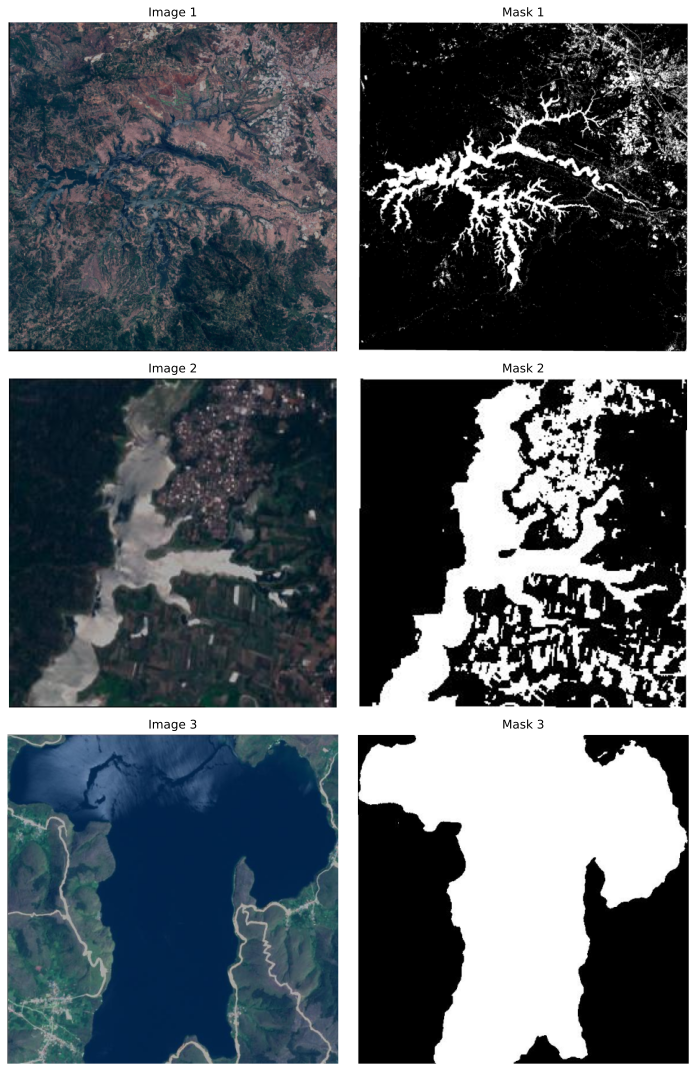

In [16]:
# Paths to the directories containing images and masks
images_path = './data/Images'
masks_path = './data/Masks'

# Function to load images and masks
def load_images_masks(image_dir, mask_dir, num_samples=3):
    image_files = sorted(os.listdir(image_dir))[:num_samples]
    mask_files = sorted(os.listdir(mask_dir))[:num_samples]
    
    images = [Image.open(os.path.join(image_dir, file)) for file in image_files]
    masks = [Image.open(os.path.join(mask_dir, file)) for file in mask_files]
    
    return images, masks

# Load the first 3 images and masks
images, masks = load_images_masks(images_path, masks_path, num_samples=3)

# Display the images and masks
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title(f'Image {i+1}')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(masks[i], cmap='gray')
    axs[i, 1].set_title(f'Mask {i+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


---

<a id='sec_preprocessing'></a>

## Preprocessing

1. **Resizing**: Standardized the image sizes to 256x256 pixels.
2. **Normalization**: Adjusted the pixel values to the range [0, 1].
3. **Contrast Enhancement**: Applied histogram equalization to enhance the contrast of the images.

Below are the examples of the preprocessed images and their corresponding masks:

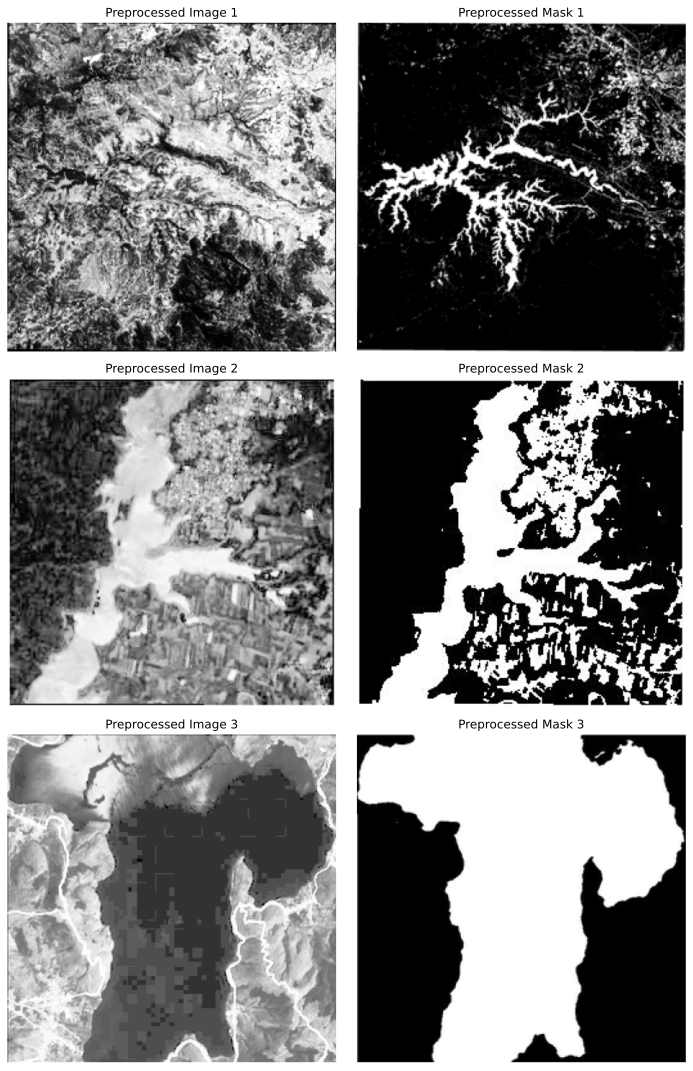

In [20]:
def preprocess_image(image, ismask):
    """
    Preprocess the input image: resize while maintaining aspect ratio, pad to make it square, 
    normalize, convert to grayscale, and enhance contrast if it's not a mask.
    
    Args:
    - image (PIL.Image): The input image to preprocess.
    - ismask (bool): Flag to indicate if the image is a mask.
    
    Returns:
    - numpy.ndarray: The preprocessed image.
    """
    target_size = (256, 256)
    
    # Resize the image while maintaining aspect ratio
    image.thumbnail(target_size, PIL.Image.LANCZOS)
    
    # Create a new image with a white background and paste the resized image onto it
    new_image = PIL.Image.new("RGB", target_size, (255, 255, 255))
    new_image.paste(
        image, ((target_size[0] - image.size[0]) // 2, (target_size[1] - image.size[1]) // 2)
    )
    
    if not ismask:
        # Convert the image to a numpy array
        image_array = np.array(new_image)
        
        # Normalize the image to [0, 1]
        image_normalized = image_array / 255.0
        
        # Convert the normalized image to 8-bit grayscale
        image_grayscale = cv.cvtColor((image_normalized * 255).astype(np.uint8), cv.COLOR_BGR2GRAY)
        
        # Enhance the contrast using histogram equalization
        image_enhanced = cv.equalizeHist(image_grayscale)
    else:
        image_enhanced = np.array(new_image.convert('L'))
    
    return image_enhanced

# Preprocess the first 3 images and masks
preprocessed_images = [preprocess_image(images[i], ismask=False) for i in range(3)]
preprocessed_masks = [preprocess_image(masks[i], ismask=True) for i in range(3)]

# Display the preprocessed images and masks
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

for i in range(3):
    axs[i, 0].imshow(preprocessed_images[i], cmap='gray')
    axs[i, 0].set_title(f'Preprocessed Image {i+1}')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(preprocessed_masks[i], cmap='gray')
    axs[i, 1].set_title(f'Preprocessed Mask {i+1}')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()


---
<a id='sec_manual_segmentation'></a>

## Manual segmentation

For the manual segmentation, the Fiji (ImageJ) software was used. Fiji is an open-source image processing package that is widely used in the life sciences for its powerful and user-friendly tools.

### Steps for Manual Segmentation in Fiji:

1. **Open Image**: Load the image into Fiji by going to `File > Open...` and selecting the image file.
2. **Convert to 8-bit**: If the image is not already in 8-bit grayscale, convert it by going to `Image > Type > 8-bit`.
3. **Thresholding**: Use the thresholding tool to create a binary mask. This can be done by going to `Image > Adjust > Threshold...` and adjusting the sliders until the water bodies are correctly highlighted.
4. **Create Binary Mask**: Apply the threshold to create a binary mask by clicking `Apply`.
5. **Save Mask**: Save the resulting mask by going to `File > Save As > PNG...`.

The following code displays the original images, the original masks, and the manually segmented masks for the selected images (100, 170, and 708).

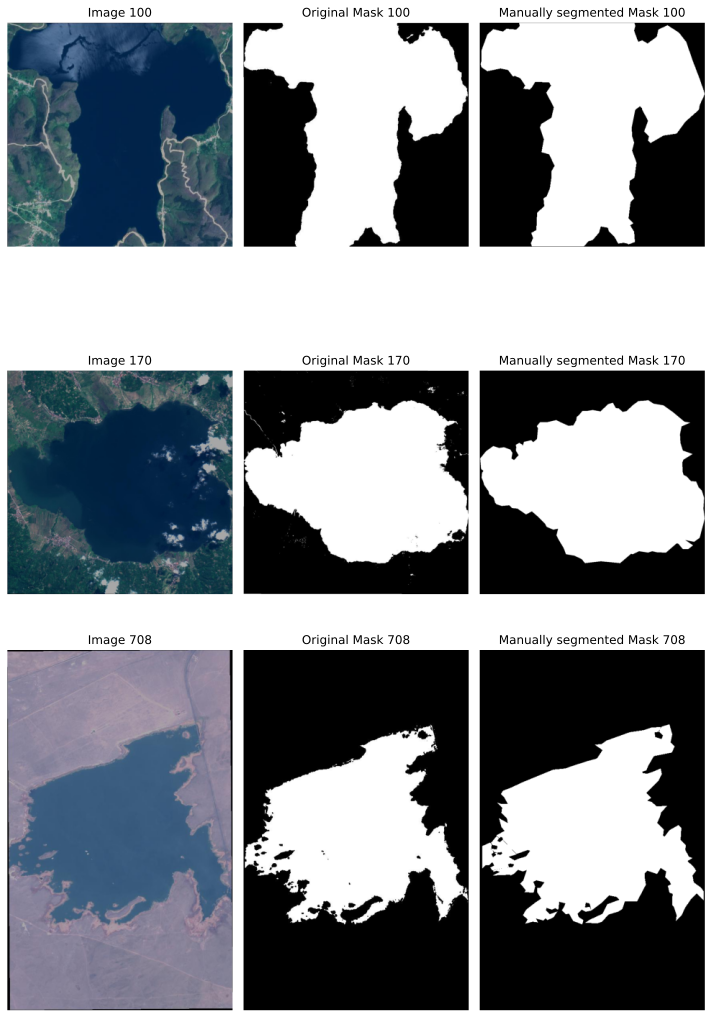

In [39]:
# Paths to the directories containing images and masks
images_path = './data/Images/'
masks_path = './data/Masks/'
manual_masks_path = './manual/'

# List of specific image indices to load
image_indices = [100, 170, 708]

# Function to load specific images and masks
def load_specific_images_masks(image_dir, mask_dir, manual_mask_dir, indices):
    images = []
    masks = []
    for index in indices:
        image_file = f'water_body_{index}.jpg'
        mask_file = f'water_body_{index}.jpg'
        manual_mask_file = f'water_body_{index}.png'
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, mask_file)
        manual_mask_path = os.path.join(manual_mask_dir, manual_mask_file)
        images.append(Image.open(image_path))
        masks.append(Image.open(mask_path))
        manual_masks.append(Image.open(manual_mask_path))
    
    return images, masks, manual_masks

# Load the specific images and masks
images, masks, manual_masks = load_specific_images_masks(images_path, masks_path, manual_masks_path, image_indices)

# Display the images and masks
fig, axs = plt.subplots(len(images), 3, figsize=(10, 5 * len(images)))

for i in range(len(images)):
    axs[i, 0].imshow(images[i])
    axs[i, 0].set_title(f'Image {image_indices[i]}')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(masks[i], cmap='gray')
    axs[i, 1].set_title(f'Original Mask {image_indices[i]}')
    axs[i, 1].axis('off')
    
    axs[i, 2].imshow(manual_masks[i], cmap='gray')
    axs[i, 2].set_title(f'Manually segmented Mask {image_indices[i]}')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()


---

<a id='sec_automated_segmentation'></a>

## Automated segmentation

$\Rightarrow$ Describe how to segment the image in Python


### Goals:
* The segmentation must be performed in Python.
* Using an external library or tool (e.g. OpenCV) is permitted.
* Implement a function `segment(image, ...)` takes an image as input and creates a segmentation mask for the structure of interest.

---

<a id='sec_evaluation'></a>

## Evaluation

$\Rightarrow$ Describe the evaluation of your results


### Goals:
* Choose an evaluation method that can compare two binary segmentation masks and computes a numeric score that describes how well these masks match (use for example the Dice score)
* Hint: specify a function `evaluate(mask1, mask2)` that computes the evaluation score(s)
* Compute mean and standard deviation of the scores of the entire dataset

---

<a id='sec_discussion'></a>

## Discussion

$\Rightarrow$ Discuss your results and experiences briefly.




---

<a id='sec_references'></a>

## References

$\Rightarrow$ Add here references as URLs.

Also declare the usage of **generative AI** here!!




<br><br><br><br><br><br><br><br>

---

<a id='sec_hints'></a>

## Hints:
* Display your data if possible.
* An easy way to show 2D images is using Pillow:


In [ ]:
# Displayin an image with Pillow
path = "../data/images/kidney-cells.jpg"
path = "../data/images/histology-image.jpg"
image = PIL.Image.open(path)
display(image)                  

In [ ]:
# If you keep the data as a numpy array (for example when using
# the OpenCV interface), you can use matplotlib to display it.
path = "../data/images/ct-brain-slices.jpg"
image = cv.imread(path)
plt.imshow(image)
plt.axis("off");


In [ ]:
# For convenience, we also provide tools.display_image()
path = "../data/images/kidney-cells.jpg"
tools.display_image(path, scale=0.5)

There are many ways how to overlay an image with the mask. Here is one option:

In [ ]:
# Enforce a (3-channel) color image
path_image = "../data/images/neurons-cultured.jpg"
image = cv.imread(path_image, cv.IMREAD_COLOR)
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Mask image
path_mask = "../data/images/neurons-cultured-mask.png"
mask = cv.imread(path_mask, cv.IMREAD_GRAYSCALE)

# Create overlay (RGB)
overlay_color = [255, 0, 0]
overlay_alpha = 0.3
overlay = image.copy()
overlay[mask > 0] = overlay_color
overlay = cv.addWeighted(image, 1 - overlay_alpha, overlay, overlay_alpha, 0)

# Display the images next to each other using a convenience function
tools.show_image_chain((image, overlay), titles=("Input", "Overlay"))


In [ ]:
# We could also create contours around the mask and display them
overlay_color = [255, 255, 0]
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
image_contours = image.copy()
cv.drawContours(image_contours, contours, -1, overlay_color, line_width)
tools.show_image_chain((image, image_contours), titles=("Input", "Contours"))

An advanced example: We can colorize the different contours with different colors.

Strategy:
- Use connected components to label the different regions using integers 
(every region has a different label)
- Assign a different color to different labels by encoding the label in 
the hue channel (HSV color space!)
- Extract contours from the mask (must be a binary image)
- Merge draw the contours with the colorized labels onto the original image

In [ ]:
# This will contain the result
image_contours = image.copy()

# Compute the "connected components" (= separate objects in the mask)
n_labels, labels = cv.connectedComponents(mask)

# Assign a different color to each label in the hue channel (HSV color space)
hue = np.uint8(150*labels/np.max(labels))
blank = 255*np.ones_like(hue)
labels = cv.merge([hue, blank, blank])

# Convert from HSV color space to RGB
labels = cv.cvtColor(labels, cv.COLOR_HSV2RGB)
# Set the background label (labels==0) to black
labels[labels==0] = 0

# Create a mask of the contours
line_width = 1
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
mask_contours = cv.drawContours(np.zeros_like(mask), contours, -1, 255, line_width)

# Assign the colored labels only along the contours
image_contours[mask_contours>0] = labels[mask_contours>0]

# Display the result
tools.show_image_chain((image, image_contours), titles=("Input", "Labeled contours"))

### How to convert a Jupyter notebook into a PDF:

- Don't forget to save this notebook before converting!
- Install nbconvert: `pip install nbconvert`
- Convert the notebook into a HTML file: `jupyter nbconvert --to html main.ipynb`  
  The file will be saved in the same folder as this Jupyter notebook
- Open the HTML in a browser and print (or save) it as a PDF
- Recommendation: If you use the Opera browser, you can save the HTML as single-page PDF. This looks the best!

In [ ]:
# Make sure you save this notebook, otherwise the HTML 
# output will not contain the latest version!!

# Make sure you have nbcovnert installed
!pip install nbconvert --quiet
# Save the notebook as HTML
!jupyter nbconvert --to html main.ipynb
